In [28]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

In [39]:
data_raw = pd.read_parquet("vhrdata").drop_duplicates(subset=None, keep='last', inplace=False)
drop_columns = ["ebs_Q_Charge", "ebs_Q_Discharge", "BCM_ebs_I_BATT", "dcdc_OverTemperature", "IC_LowBatteryvoltage",
                "DCDC_realInputVoltage", "DCDC_realInputCurrent"]
data_raw = data_raw.drop(columns=drop_columns)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672419 entries, 0 to 1672418
Data columns (total 46 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   vin                       1672419 non-null  object 
 1   collect_ts                1672419 non-null  int64  
 2   uuid                      1672419 non-null  object 
 3   model_name                1672419 non-null  object 
 4   series_code               1672419 non-null  object 
 5   msg_create_time           1672419 non-null  object 
 6   vcu_VehicleMode           1670933 non-null  float32
 7   vcu_vehicleSpeed          1670936 non-null  float32
 8   VCU_VehicleSpeedValid     1670936 non-null  float32
 9   vcu_state                 1672019 non-null  float32
 10  bms_SOC                   1668674 non-null  float32
 11  bms_state                 1672419 non-null  float32
 12  BCM_ebs_U_BATT            166432 non-null   float32
 13  BCM_ebs_SOC               1

In [45]:
#
a1 = data_raw[(data_raw.BCM_ebs_U_BATT > 0) & (data_raw.BCM_ebs_U_BATT <= 10.5)].size
b1 = data_raw[(data_raw.BCM_ebs_U_BATT > 0) & (data_raw.BCM_ebs_U_BATT <= 10.5)
              & (data_raw.dcdc_realOutputVoltage <= 10.5) & (data_raw.dcdc_realOutputVoltage > 0)
              #& (data_raw.vcu_dcdc_enable == 0)
              ].size
print(a1, b1, b1 / a1)

12650 12558 0.9927272727272727


array([[<Axes: xlabel='BCM_ebs_U_BATT', ylabel='BCM_ebs_U_BATT'>,
        <Axes: xlabel='dcdc_realOutputVoltage', ylabel='BCM_ebs_U_BATT'>,
        <Axes: xlabel='dcdc_realOutputCurrent', ylabel='BCM_ebs_U_BATT'>],
       [<Axes: xlabel='BCM_ebs_U_BATT', ylabel='dcdc_realOutputVoltage'>,
        <Axes: xlabel='dcdc_realOutputVoltage', ylabel='dcdc_realOutputVoltage'>,
        <Axes: xlabel='dcdc_realOutputCurrent', ylabel='dcdc_realOutputVoltage'>],
       [<Axes: xlabel='BCM_ebs_U_BATT', ylabel='dcdc_realOutputCurrent'>,
        <Axes: xlabel='dcdc_realOutputVoltage', ylabel='dcdc_realOutputCurrent'>,
        <Axes: xlabel='dcdc_realOutputCurrent', ylabel='dcdc_realOutputCurrent'>]],
      dtype=object)

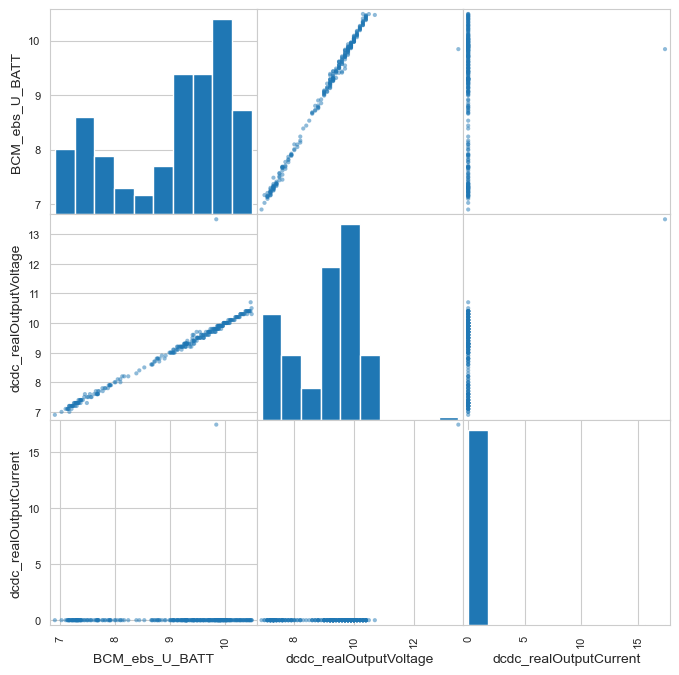

In [48]:
attributes = ["BCM_ebs_U_BATT", "dcdc_realOutputVoltage","dcdc_realOutputCurrent"]
scatter_matrix(data_raw[(data_raw.BCM_ebs_U_BATT > 0) & (data_raw.BCM_ebs_U_BATT <= 10.5)][attributes], figsize=(8, 8))

1. ebs_Q_Charge ebs_Q_Discharge BCM_ebs_I_BATT  dcdc_OverTemperature 一直为 0.0，同时又不是状态值，直接删除这些特征
2. IC_LowBatteryvoltage  DCDC_realInputVoltage  DCDC_realInputCurrent 全为空，直接删除这些特征
3. DCDC_MCU_HVIL_Warning DCDC_BMS_HVIL_Warning DCDC_HV_InterlockStatus1 DCDC_HV_InterlockStatus dcdc_deratingStatus 作为状态值先保留
4. BCM_ebs_U_BATT 中间存在 3.0 的值将这部分提取出来进一步观察

array([[<Axes: xlabel='BCM_ebs_U_BATT', ylabel='BCM_ebs_U_BATT'>,
        <Axes: xlabel='dcdc_realOutputVoltage', ylabel='BCM_ebs_U_BATT'>],
       [<Axes: xlabel='BCM_ebs_U_BATT', ylabel='dcdc_realOutputVoltage'>,
        <Axes: xlabel='dcdc_realOutputVoltage', ylabel='dcdc_realOutputVoltage'>]],
      dtype=object)

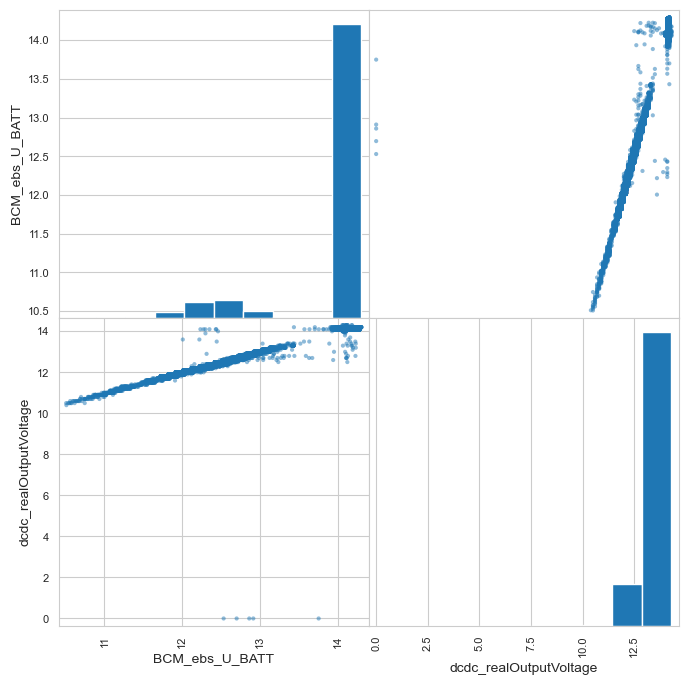

In [47]:
attributes = ["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]
scatter_matrix(data_raw[(data_raw.BCM_ebs_U_BATT < 14.5) & (data_raw.BCM_ebs_U_BATT > 10.5)][attributes], figsize=(8, 8))

In [44]:
data_raw[(data_raw.BCM_ebs_U_BATT > 0) & (data_raw.BCM_ebs_U_BATT <= 10.5)& (data_raw.dcdc_realOutputVoltage > 10.5)]["vin"].value_counts()

vin
LM8F7D792NA012370    1
LM8F7D892NA001321    1
Name: count, dtype: int64

In [ ]:
data_raw["vin"].drop_duplicates()

In [ ]:
import seaborn as sns

sns.distplot(data_raw[data_raw.dcdc_realOutputVoltage < 11.].dcdc_realOutputVoltage, hist=True, kde=False)

In [ ]:
pd.DataFrame(data_raw[data_raw.BCM_ebs_U_BATT > 14.25].BCM_ebs_U_BATT.value_counts()).sort_values(by='BCM_ebs_U_BATT')

In [ ]:
import seaborn as sns

sns.distplot(data_raw[data_raw.BCM_ebs_U_BATT > 14.252].BCM_ebs_U_BATT, hist=True, kde=False)

In [ ]:
data_raw.describe()

In [ ]:
pd.DataFrame(data_raw["BCM_ebs_U_BATT"].value_counts()).sort_values(by='BCM_ebs_U_BATT')

In [ ]:
# 清除异常数据之后的数据
data_raw = data_raw.fillna(method='ffill')
data = data_raw[(data_raw.BCM_ebs_U_BATT > 3.) & (data_raw.BCM_ebs_U_BATT < 18.)
                & (data_raw.BCM_ebs_SOC <= 100.)
                & (data_raw.bms_pLimitDrive <= 400.)
                ]
data.info()

In [ ]:
data["vin"].value_counts()

In [ ]:
data.info()

In [ ]:
import matplotlib.pyplot as plt

data.BCM_ebs_U_BATT.hist(bins=10, figsize=(15, 3))
plt.show()

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["BCM_ebs_U_BATT", "BCM_ebs_SOC"]
scatter_matrix(data[attributes], figsize=(8, 8))

In [ ]:
data[(data.bms_SOC >= 30.) & (data.BCM_ebs_U_BATT < 10.5)]["vin"].value_counts()

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["BCM_ebs_U_BATT", "BCM_ebs_SOC"]
scatter_matrix(data[data["vin"] == "LM8F7D895NA004066"][attributes], figsize=(8, 8))

In [ ]:


attributes = ["BCM_ebs_U_BATT", "DCDC_AlerState"]
scatter_matrix(data[attributes], figsize=(8, 8))

In [ ]:
data.BCM_ebs_U_BATT.describe()

In [ ]:
import seaborn as sns

sns.distplot(data.bms_SOC, hist=True, kde=True)

In [ ]:
import seaborn as sns

sns.distplot(data[data.BCM_ebs_U_BATT > 10.0].BCM_ebs_U_BATT, hist=True, kde=True)